# (09) Neural analysis (GABAN)

**Motivation**: <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Trainer paths

In [2]:
path = results_dir()
path = pathlib.Path(path)

trainer_paths = set()
pat = '**/Trainer' # '**/*fixate1*/**/Trainer'
for p in path.rglob(pat):
    if p.is_dir():
        trainer_paths.add(str(p))
trainer_paths = sorted(trainer_paths)
len(trainer_paths)

34

### Select a subset of fitted models

In [3]:
which_sims = [
    'obj1',
    'fixate0', 'fixate1', 'fixate2',
    'transl0', 'transl1', 'transl2',
]
which_nf = [280, 420]

selected_fits = []
for fit_path in trainer_paths:
    fit_name = fit_path.split('/')[-2]
    if fit_name == 'fixate2_nf-420_beta-0.15_(2023_04_27,13:57)':
        continue
    
    info = fit_name.split('_')
    i = info.index([
        e for e in info
        if 'nf-' in e
    ].pop())
    nf = int(info[i].split('-')[1])
    cond = (
        nf not in which_nf or
        not any(e in fit_name for e in which_sims)
    )
    if cond:
        continue
    else:
        selected_fits.append(fit_path)
len(selected_fits)

26

### Select main ground truth variables

In [4]:
labels_main = [
    'fix_x',
    'fix_y',
    'slf_v_x',
    'slf_v_y',
    'slf_v_z',
    'obj0_x',
    'obj0_y',
    'obj0_z',
    'obj0_v_x',
    'obj0_v_y',
    'obj0_v_z',
]

In [5]:
for fit_path in selected_fits:
    fit_name = fit_path.split('/')[-2]
    f = pjoin(tmp_dir, 'neural_analysis', f"{fit_name}.npy")
    if not os.path.isfile(f):
        print(fit_name, os.path.isfile(f))

## Neural results

In [6]:
%%time

pbar = tqdm(selected_fits)
for fit_path in pbar:
    fit_name = fit_path.split('/')[-2]
    f = pjoin(tmp_dir, 'neural_analysis', f"{fit_name}.npy")
    if os.path.isfile(f):
        continue
    pbar.set_description(fit_name)
    
    f = pjoin(tmp_dir, 'trainer_analysis', fit_name)
    f = f"{f}.npy"
    if os.path.isfile(f):
        everything = np.load(f, allow_pickle=True).item()
    else:
        print(f"not found: {fit_name}")
        continue

    df, df_all, ro_all, args, tr = summarize_neural_fits(
        fit_name=fit_name, device='cuda')

    labels = tr.dl_trn.dataset.f + tr.dl_trn.dataset.f_aux
    selected = [
        i for i, lbl in
        enumerate(labels)
        if lbl in labels_main
    ]
    
    # extract neural results
    neural_results = collections.defaultdict(dict)
    for key, ro in ro_all.items():
        for cell, m in ro.mod.items():
            data = ro.validate(cell)
            pred = m.predict(data['x'])
            if ro.has_repeats:
                pred_tst = m.predict(data['x_tst'])
            else:
                pred_tst = None

            # STA (model)
            sta_model = compute_sta(
                n_lags=0,
                stim=ro.stim[ro.good],
                spks=pred.reshape(-1, 1),
            ).squeeze()

            # STA
            lag = ro.best_lag[cell]
            inds = ro.good.copy()
            inds = inds[inds > lag]
            inds = inds - lag
            sta_spks = compute_sta(
                n_lags=0,
                stim=ro.stim[inds],
                spks=data['y'].reshape(-1, 1),
            ).squeeze()

            # perm importance
            perm = sk_inspect.permutation_importance(
                estimator=m,
                X=data['x_tst' if ro.has_repeats else 'x'],
                y=data['y_tst' if ro.has_repeats else 'y'],
                random_state=0,
                n_repeats=10,
            )
            perm_mu = np.maximum(0, perm['importances_mean'])
            perm_sd = perm['importances_std']

            # Probs
            p_z_given_neuron = perm_mu / perm_mu.sum()
            a = 1 - entropy_normalized(p_z_given_neuron, axis=0)
            p_g_given_z = np.maximum(0, everything['importances_mu'])[selected]
            p_g_given_z = p_g_given_z / p_g_given_z.sum(0, keepdims=True)
            p_g_given_neuron = p_g_given_z @ p_z_given_neuron

            k = f"{key}_{cell}"
            neural_results['data'][k] = data
            neural_results['pred'][k] = pred
            neural_results['pred_tst'][k] = pred_tst
            neural_results['sta_model'][k] = sta_model
            neural_results['sta_spks'][k] = sta_spks
            neural_results['perm_mu'][k] = perm_mu
            neural_results['perm_sd'][k] = perm_sd
            neural_results['alignment_score'][k] = a
            neural_results['p_g_given_z'][k] = p_g_given_z
            neural_results['p_z_given_neuron'][k] = p_z_given_neuron
            neural_results['p_g_given_neuron'][k] = p_g_given_neuron
            neural_results['labels'][k] = list(np.array(labels)[selected])

    # save
    save_obj(
        obj=neural_results,
        file_name=fit_name,
        save_dir=pjoin(tmp_dir, 'neural_analysis'),
        verbose=True,
        mode='npy',
    )
    torch.cuda.empty_cache()

100%|████████████████████████████████████████| 26/26 [00:00<00:00, 60820.92it/s]

CPU times: user 6.33 ms, sys: 0 ns, total: 6.33 ms
Wall time: 4.94 ms


In [7]:
for fit_path in selected_fits:
    fit_name = fit_path.split('/')[-2]
    f = pjoin(tmp_dir, 'neural_analysis', f"{fit_name}.npy")
    if not os.path.isfile(f):
        print(fit_name, os.path.isfile(f))

---

## Tmp code below

---

In [5]:
%%time

pbar = tqdm(selected_fits)
for fit_path in pbar:
    fit_name = fit_path.split('/')[-2]
    pbar.set_description(fit_name)
    
    f = pjoin(tmp_dir, 'trainer_analysis', fit_name)
    f = f"{f}.npy"
    if os.path.isfile(f):
        everything = np.load(f, allow_pickle=True).item()
    else:
        print(f"not found: {fit_name}")
        continue

    df, df_all, ro_all, args, tr = summarize_neural_fits(
        fit_name=fit_name, device='cpu')

    labels = tr.dl_trn.dataset.f + tr.dl_trn.dataset.f_aux
    selected = [
        i for i, lbl in
        enumerate(labels)
        if lbl in labels_main
    ]
    
    # extract neural results
    neural_results = collections.defaultdict(dict)
    for key, ro in tqdm(ro_all.items()):
        for cell, m in ro.mod.items():
            data = ro.validate(cell)
            pred = m.predict(data['x'])
            if ro.has_repeats:
                pred_tst = m.predict(data['x_tst'])
            else:
                pred_tst = None

            # STA (model)
            sta_model = compute_sta(
                n_lags=0,
                stim=ro.stim[ro.good],
                spks=pred.reshape(-1, 1),
            ).squeeze()

            # STA
            lag = ro.best_lag[cell]
            inds = ro.good.copy()
            inds = inds[inds > lag]
            inds = inds - lag
            sta_spks = compute_sta(
                n_lags=0,
                stim=ro.stim[inds],
                spks=data['y'].reshape(-1, 1),
            ).squeeze()

            # perm importance
            perm = sk_inspect.permutation_importance(
                estimator=m,
                X=data['x_tst' if ro.has_repeats else 'x'],
                y=data['y_tst' if ro.has_repeats else 'y'],
                random_state=0,
                n_repeats=10,
            )
            perm_mu = np.maximum(0, perm['importances_mean'])
            perm_sd = perm['importances_std']

            # Probs
            p_z_given_neuron = perm_mu / perm_mu.sum()
            a = 1 - entropy_normalized(p_z_given_neuron, axis=0)
            p_g_given_z = np.maximum(0, everything['importances_mu'])[selected]
            p_g_given_z = p_g_given_z / p_g_given_z.sum(0, keepdims=True)
            p_g_given_neuron = p_g_given_z @ p_z_given_neuron
        break
    break

fixate0_nf-280_beta-10_(2023_05_07,04:49):   0%|         | 0/14 [00:42<?, ?it/s]

CPU times: user 11min 41s, sys: 34.2 s, total: 12min 15s
Wall time: 42.4 s


In [8]:
fit_name

'fixate0_nf-280_beta-10_(2023_05_07,04:49)'

In [9]:
key, cell

('YUWEI_clu036', 0)

In [10]:
1 - entropy_normalized(p_z_given_neuron, axis=0)

0.42331899745354473

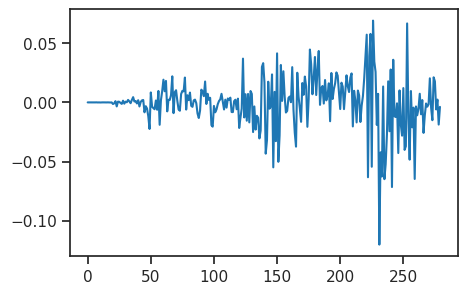

In [11]:
plt.plot(m.coef_)

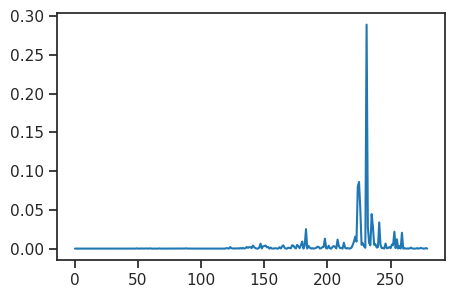

In [12]:
plt.plot(p_z_given_neuron)

In [13]:
sum(p_z_given_neuron), sum(p_g_given_neuron)

(1.0, 1.0)

In [14]:
collections.Counter(np.round(p_g_given_z.sum(0), 3))

Counter({1.0: 280})

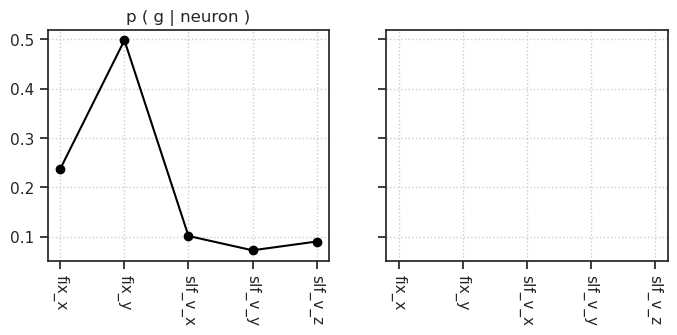

In [15]:
fig, axes = create_figure(1, 2, (8, 3), 'all', 'all')
axes[0].plot(p_g_given_neuron, marker='o', color='k')
# axes[1].plot(p_neuron_given_g, marker='o', color='silver')

axes[0].set_title('p ( g | neuron )')
# axes[1].set_title('p ( neuron | g )')

axes[0].set(
    xticks=range(len(selected)),
    xticklabels=list(np.array(labels)[selected]),
)
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=-90)
    ax.grid()
plt.show()

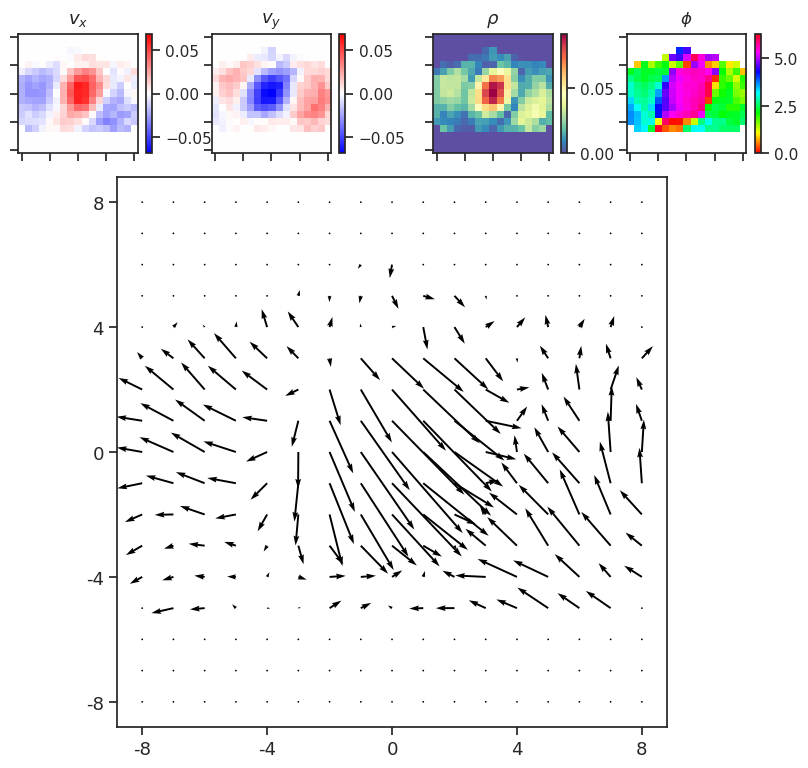

In [16]:
show_opticflow_full(sta_model);

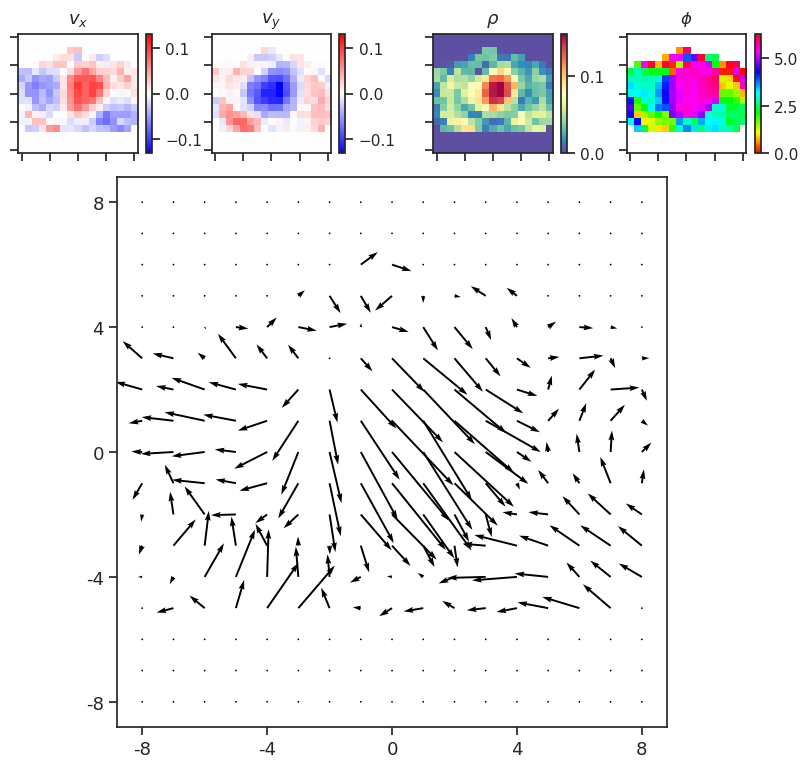

In [17]:
show_opticflow_full(sta_spks);